In [1]:
!pip install pandas numpy tensorflow tqdm matplotlib seaborn scikit-learn scikit-image keras


In [3]:
# Dependencies

import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm 
from IPython import display 
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

## Data
https://www.kaggle.com/techsash/waste-classification-data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Atharva\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1


In [6]:
# Directory paths for importing data

base_dir = r"C:\Users\Atharva\.cache\kagglehub\datasets\techsash\waste-classification-data\versions\1\DATASET"
train_dir = os.path.join(base_dir, "Train")
test_dir = os.path.join(base_dir, "Test")

In [7]:
# Os path join (train)

train_o = glob.glob(os.path.join(train_dir, 'O', '*.jpg'))
train_r = glob.glob(os.path.join(train_dir, 'R', '*.jpg'))

a = len(train_o)
b = len(train_r)

print("Number of training samples: {}".format(a+b))

Number of training samples: 22564


In [8]:
# Os path join (test)

test_o = glob.glob(os.path.join(test_dir, 'O', '*.jpg'))
test_r = glob.glob(os.path.join(test_dir, 'R', '*.jpg'))

a = len(test_o)
b = len(test_r)


print("Number of test samples: {}".format(a+b))

Number of test samples: 2513


## Data Augnentation

In [10]:
# Datagenerators

train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 10,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

## Training Dataset

In [12]:
# Train dataset

train_ds  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = (180, 180),
                                                   class_mode = 'categorical',
                                                   batch_size = 32, 
                                                   subset = 'training')

Found 18052 images belonging to 2 classes.


## Validate Data

In [16]:
# Validate dataset

valid_ds = valid_datagen.flow_from_directory(directory = train_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32, 
                                                  subset = 'validation')

Found 4512 images belonging to 2 classes.


## Test Dataset

In [21]:
# Test dataset

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = (180, 180),
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle=False)

Found 2513 images belonging to 2 classes.


In [22]:
# Check classes

print(train_ds.class_indices)
print(test_ds.class_indices)

{'O': 0, 'R': 1}
{'O': 0, 'R': 1}


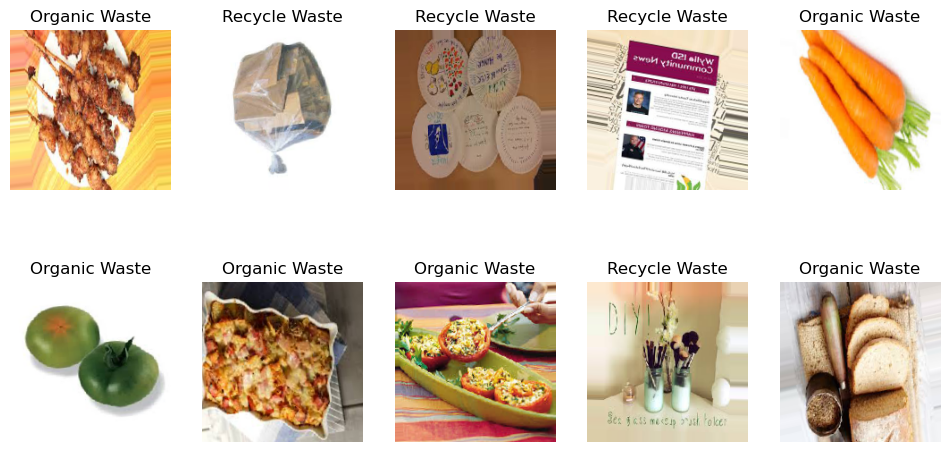

In [23]:
# Viewing images

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12,6))
#plt.subplots_adjust(hspace=0.55)

for i in range(2):
    for j in range(5):
        rand1 = np.random.randint(len(train_ds))
        rand2 = np.random.randint(32)
        ax[i,j].imshow(train_ds[rand1][0][rand2])
        ax[i,j].axis('off')
        label = train_ds[rand1][1][rand2]
        # print(label[0])
        if label[0] == 0:
            ax[i,j].set_title('Recycle Waste')
        else:
            ax[i,j].set_title('Organic Waste')

plt.tight_layout
plt.show()

## Model

In [26]:
# Defining callbacks

filepath = './final_model_weights.keras'


earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [30]:
# Base model

base_model = VGG16(input_shape=(180,180,3), 
                   include_top=False,
                   weights="imagenet")

In [31]:
# Freezing layers 

for layer in base_model.layers:
    layer.trainable=False

In [32]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Visualizing Base model Layers with test images

block1_conv1
64


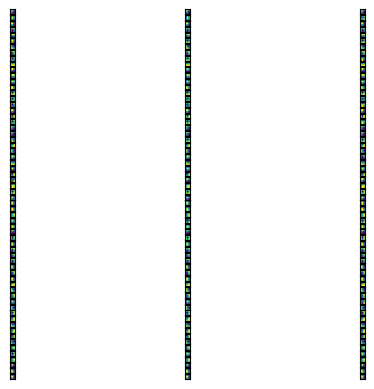

block1_conv2
64


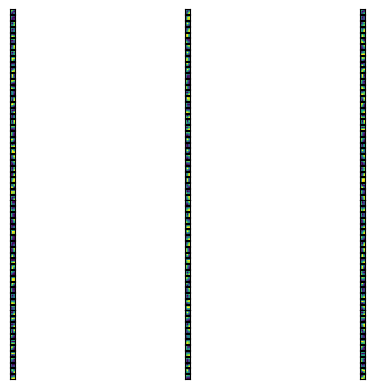

block2_conv1
128


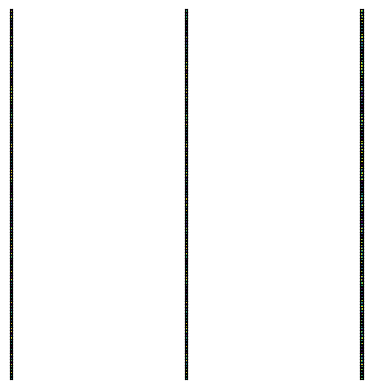

block2_conv2
128


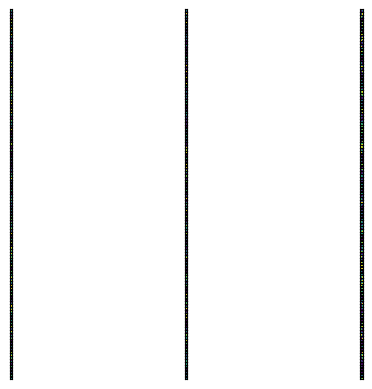

block3_conv1
256


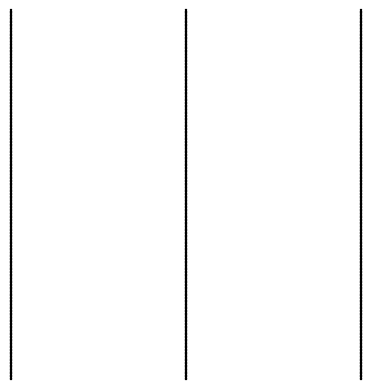

block3_conv2
256


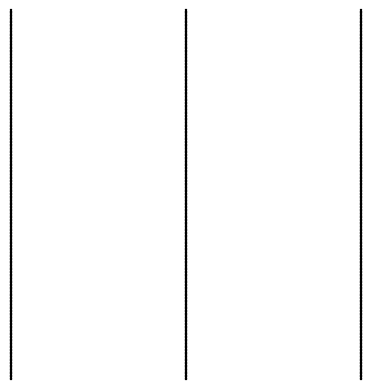

block3_conv3
256


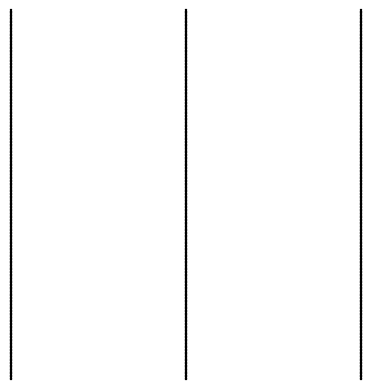

block4_conv1
512


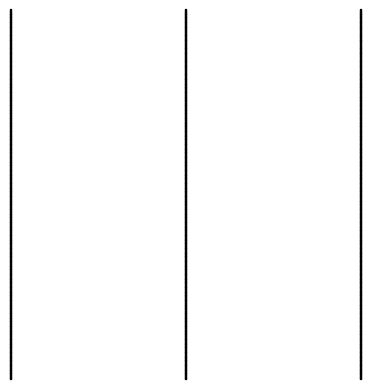

block4_conv2
512


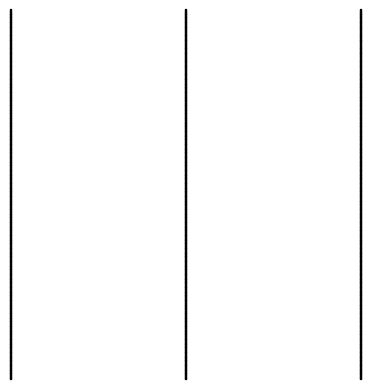

block4_conv3
512


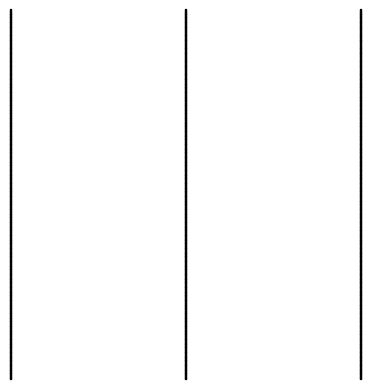

block5_conv1
512


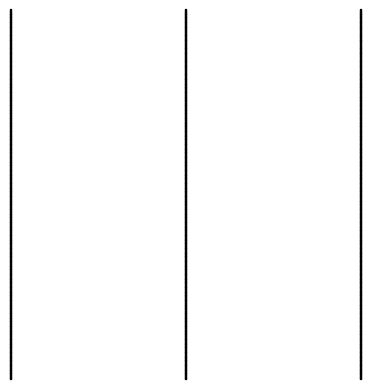

block5_conv2
512


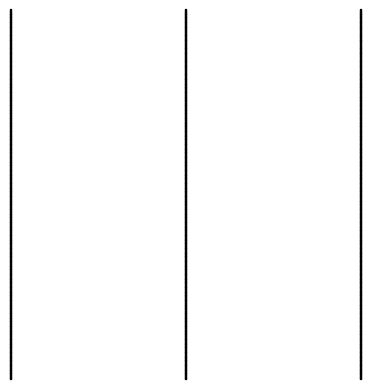

block5_conv3
512


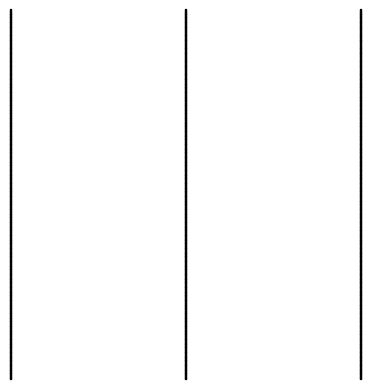

In [34]:
# Iterate thru all the layers of the model

for layer in base_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # filters, biases = layer.get_weights()
        print(layer.name)
        # print(layer.name, filters.shape)
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        filter_cnt=1
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

In [ ]:
# Visualize feature maps for an organic image

# Image path
img_path=test_dir + '/O' + '/O_12825.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile our images in a matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features*5, scale*4))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='bwr' )

# Disable tf warning
logging.getLogger('tensorflow').disabled = True

In [ ]:
# Visualize feature maps for a recycled image

# Image path
img_path=test_dir + '/R' + '/R_11107.jpg'

# Define a new model, input=image 
# Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in base_model.layers[1:]]

# Visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = base_model.input, outputs = successive_outputs)

# Load the input image
img = load_img(img_path, target_size=(180, 180))

# Convert ht image to Array of dimension (180,180,3)
x = img_to_array(img)                           
x = x.reshape((1,) + x.shape)

# Rescale by 1/255
x /= 255.0

# Run input image through our visualization network to obtain all intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers, so we can have them as part of our plot
layer_names = [layer.name for layer in base_model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

    n_features = feature_map.shape[-1]  # number of features in the feature map
    size = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
        
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
        
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features*5, scale*4) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='bwr' )

# Ignore Runtimewarning
warnings.filterwarnings('ignore')

## Adding layers to Base Model

In [ ]:
# Defining Layers
model=Sequential()
model.add(base_model) 
model.add(Dropout(0.2))
model.add(Flatten())

# Add dense layers
model.add(BatchNormalization())
model.add(Dense(5000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1000,activation="relu",kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation="relu",kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(2,activation="softmax"))

In [ ]:
# Show model summary (with custom layers)

model.summary()

## Model Training

In [ ]:
# Model fit (training)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC(name = 'auc')])
model_history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks = callback_list, verbose = 1)

In [ ]:
# Storing loss and accuracy values into a DataFrame to save permanently for plots

# Store model.fit results in a variable
history = model_history

# Save as DataFrame:     
history_df = pd.DataFrame(history.history) 
history_df

In [ ]:
# Save as csv
history_df.to_csv('C:\Users\Atharva\Waste Classifier/model_history.csv', index=False)

In [ ]:
# Evaluate overall loss and accuracy for test data
model.evaluate(test_ds)

In [ ]:
# Store final values as variables

loss_final = 0.3659922480583191
auc_final = 0.9392455220222473
print(f"The final loss was {loss_final}, and the final accuracy was {auc_final}.")